In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

/Users/michael/miniconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import pandas as pd
import simplejson as json
from simplejson import JSONDecodeError

with open('../results/run11/driver.json') as fh:
    json_data = [json.loads(row) for row in fh]
df = pd.DataFrame(json_data).rename(columns={'command': 'program'})
df['n'] = df['n'].astype('int')

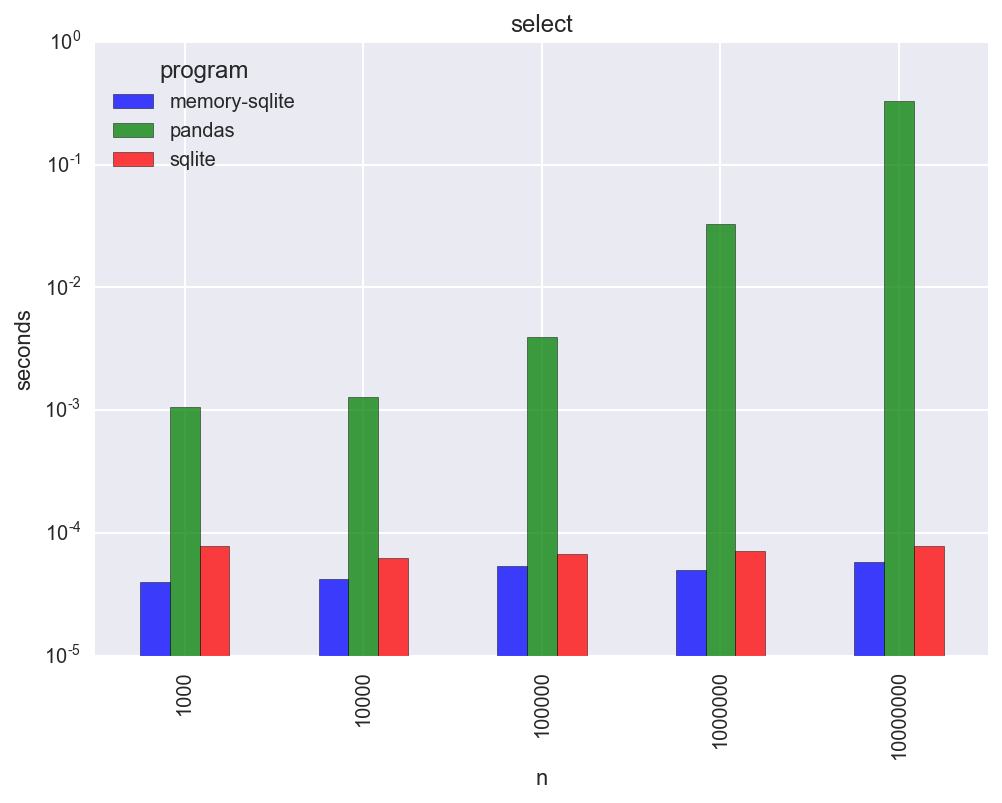

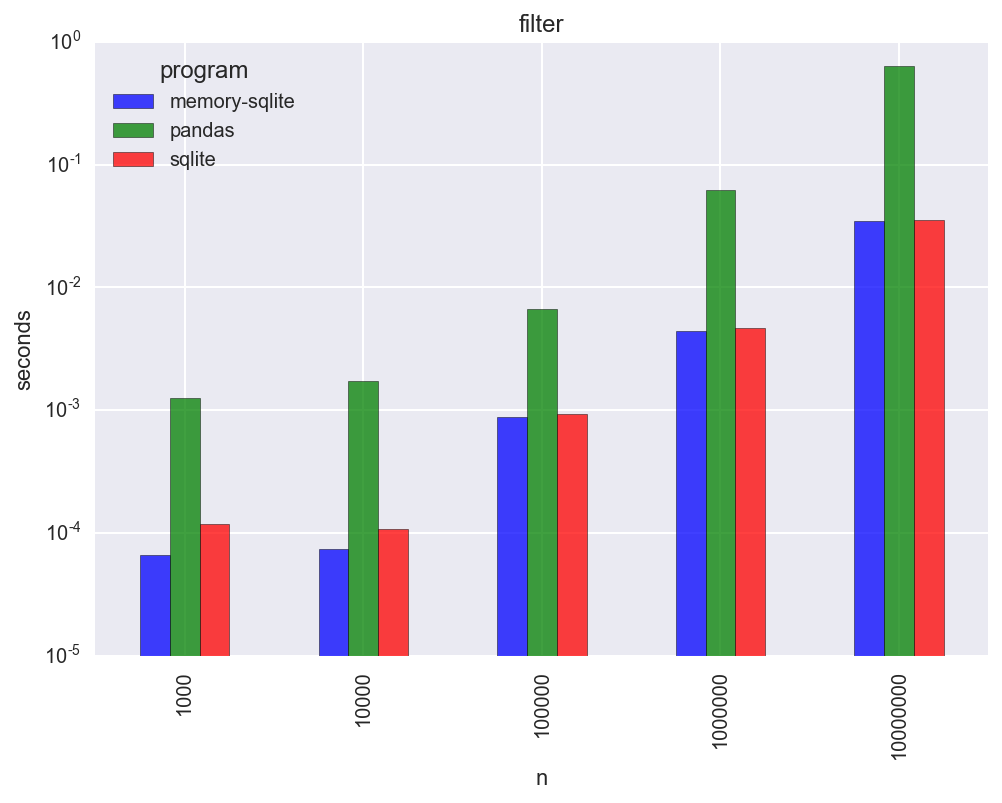

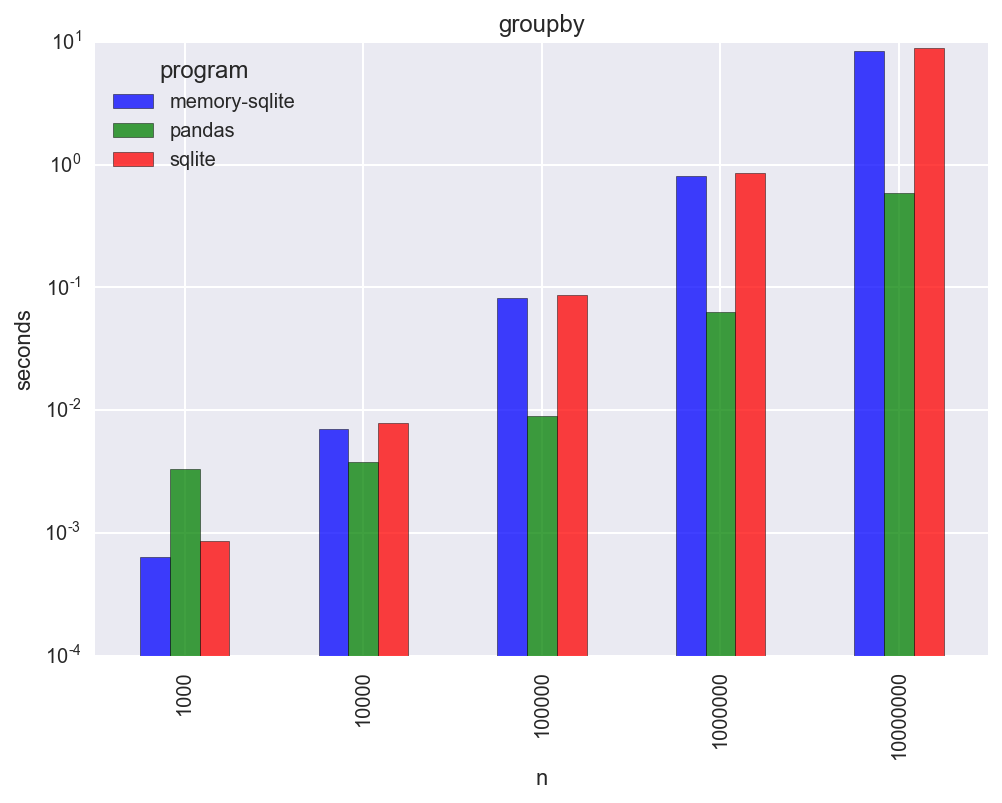

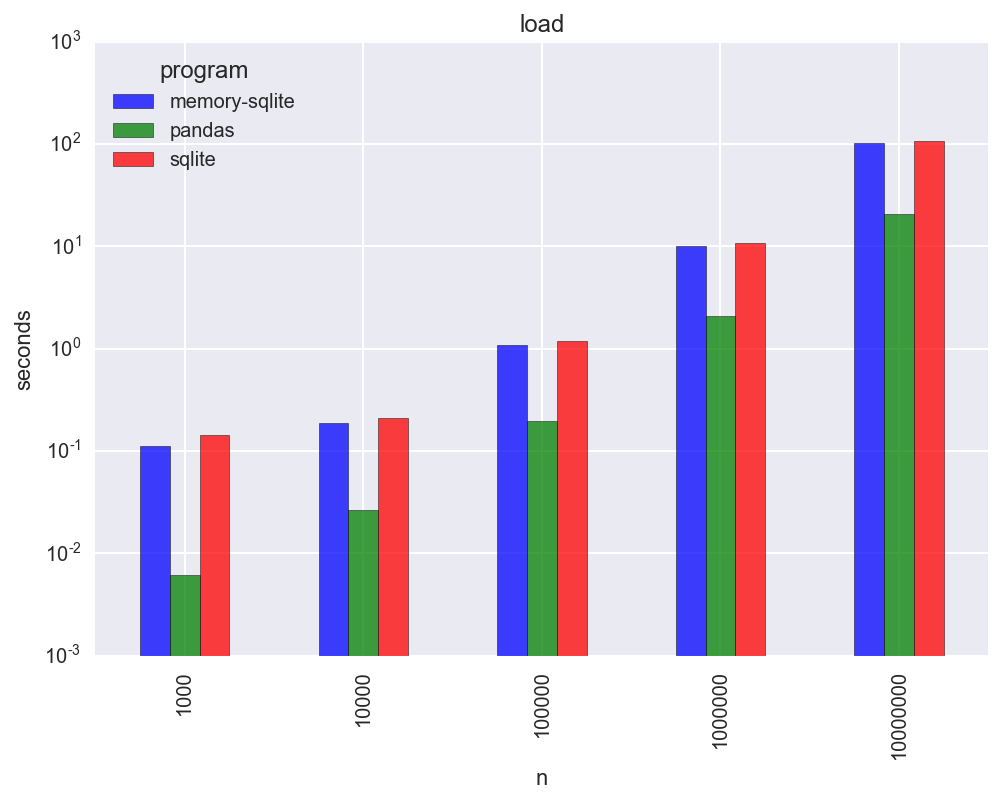

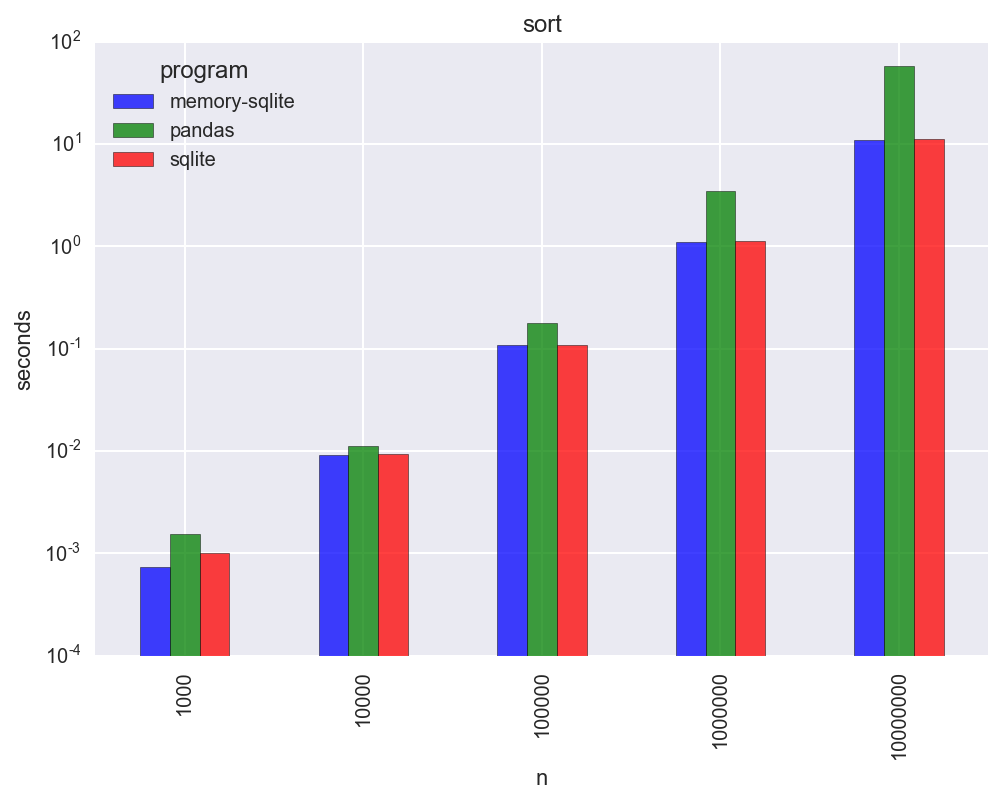

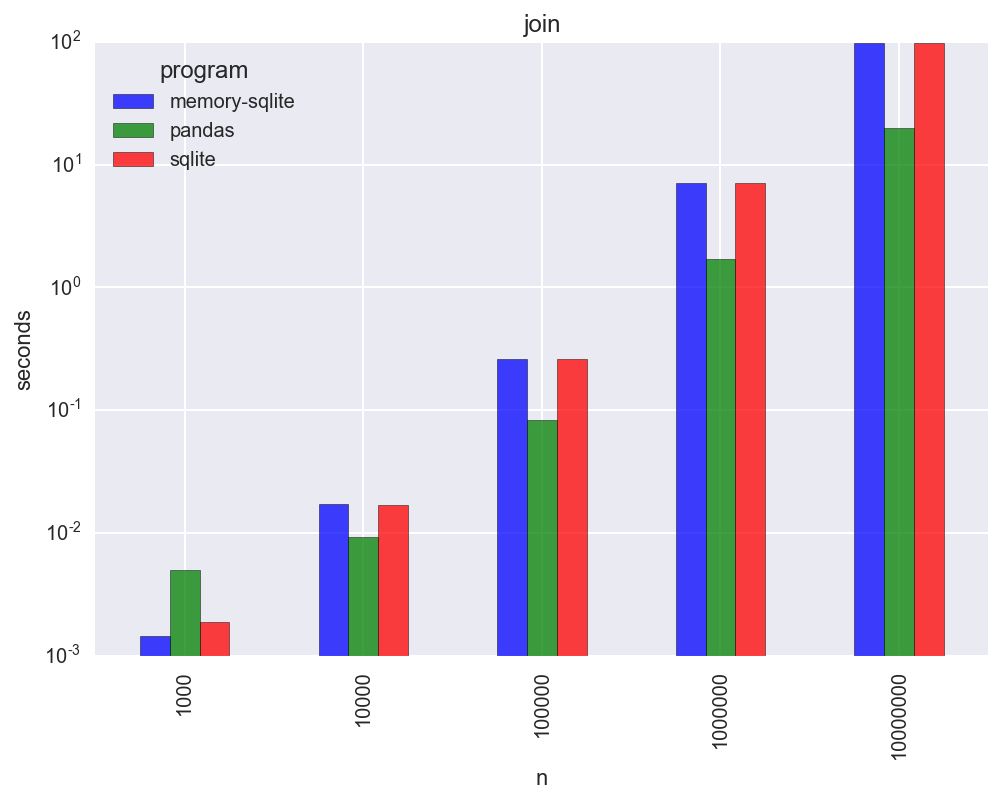

In [3]:
for task in  ['select', 'filter','groupby', 'load', 'sort', 'join']:
    group = df.groupby(['n', 'program'])[task]
    m = group.mean().unstack()
    e = group.std().unstack()
    ax = m.plot(kind='bar', logy=True, title=task, alpha=.75)
    ax.set_ylabel("seconds")

## Loading data in sqlite shell

There is no significant speedup from loading sqlite in its own shell vs. via pandas

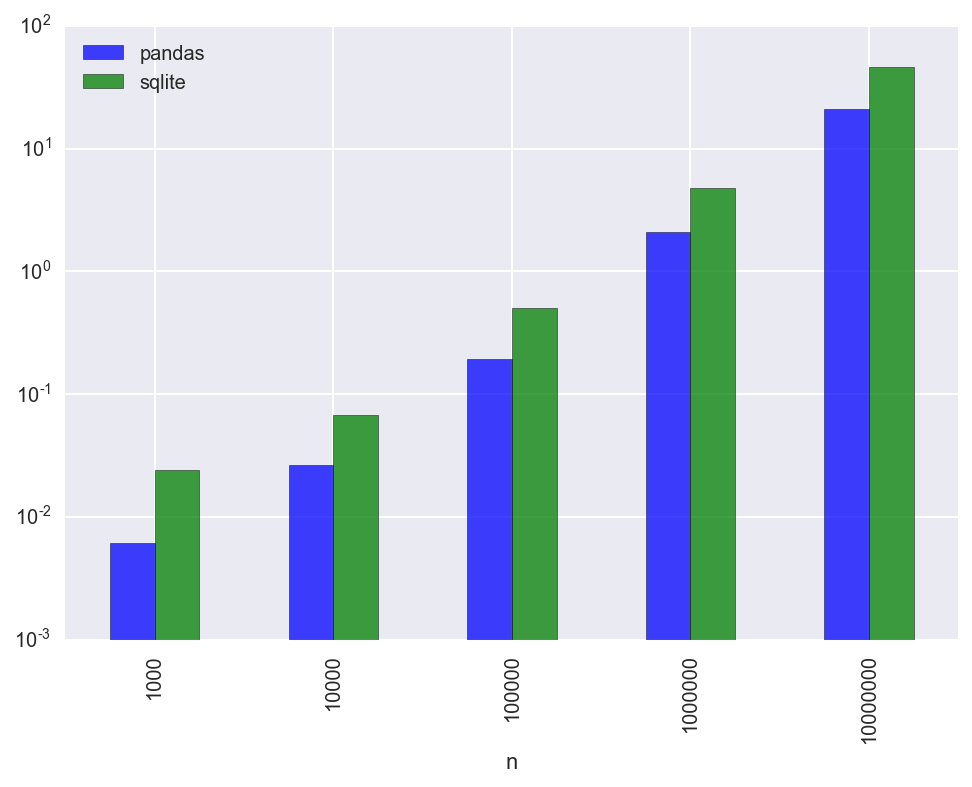

In [4]:
sqlite_load = pd.Series({
    1000: 0.024,
    10000: 0.068,
    100000: 0.499,
    1000000: 4.740,
    10000000: 46.121,
})

pandas_load = df.groupby(['program', 'n'])['load'].mean().loc['pandas']

pd.DataFrame({
    'sqlite': sqlite_load,
    'pandas': pandas_load
}).plot(kind='bar', alpha=.75, logy=True)

program  memory-sqlite    pandas     sqlite
groupby       0.813791  0.063251   0.859696
load         10.178923  2.077475  10.910871
program  memory-sqlite    pandas    sqlite
select         0.00005  0.033023  0.000071
filter         0.00437  0.062210  0.004649


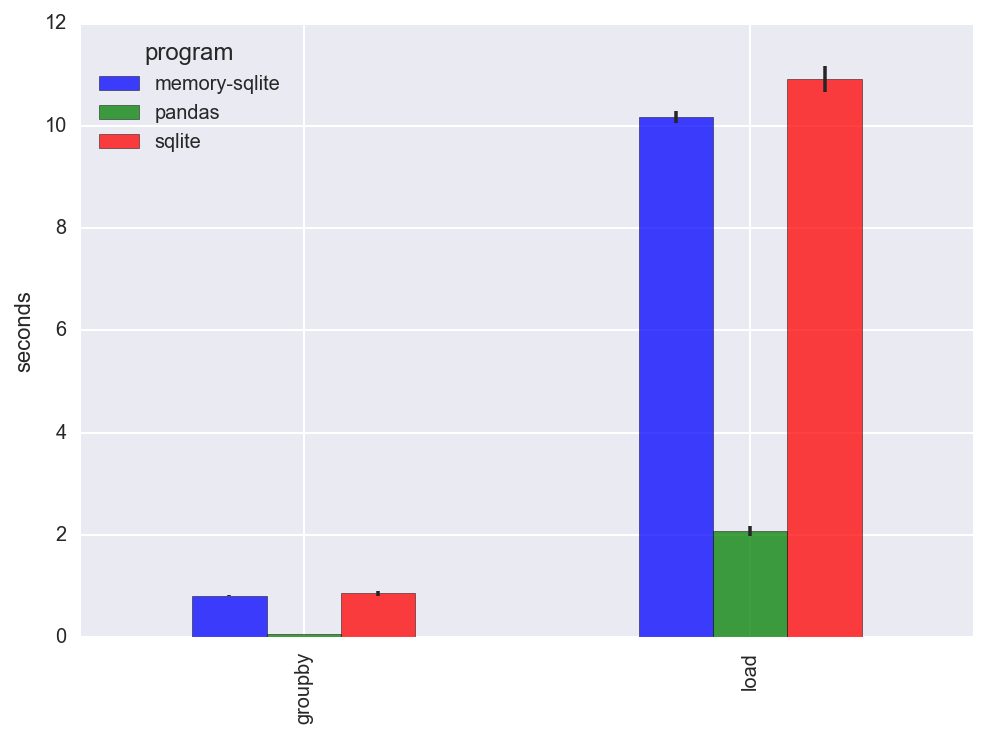

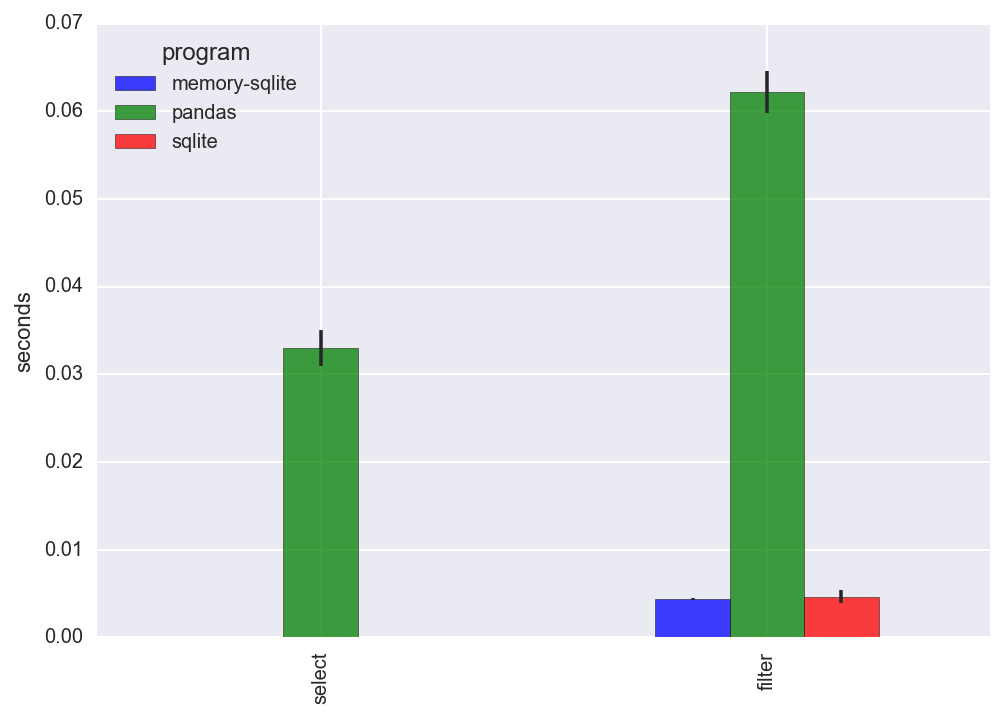

In [5]:
def graph(df, labels, n):
    group = df.groupby(['n', 'program'])[labels]
    m = group.mean().loc[n].T
    s = group.std().loc[n].T
    ax = m.plot(kind='bar', yerr=s, alpha=0.75)
    ax.set_ylabel("seconds")
    print m
    
graph(df, ['groupby', 'load'], 1000000)
graph(df, ['select', 'filter'], 1000000)

Loading 10 million rows of data into a process with 1MB of data crashes pandas

```bash
$ ulimit -Sv 1000000
$ ulimit -Sv
1000000
$ make all n=10000000 program=pandas
python driver/driver.py 10000000 data/sample.10000000.csv data/bonus.10000000.csv pandas
Traceback (most recent call last):
  File "driver/driver.py", line 31, in <module>
    getattr(driver, task)()
  File "/home/vagrant/sql_vs_pandas/driver/pandas_driver.py", line 14, in load
    self.df_employee = pd.read_csv(self.employee_file)
  File "/opt/conda/lib/python2.7/site-packages/pandas/io/parsers.py", line 562, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/opt/conda/lib/python2.7/site-packages/pandas/io/parsers.py", line 325, in _read
    return parser.read()
  File "/opt/conda/lib/python2.7/site-packages/pandas/io/parsers.py", line 815, in read
    ret = self._engine.read(nrows)
  File "/opt/conda/lib/python2.7/site-packages/pandas/io/parsers.py", line 1314, in read
    data = self._reader.read(nrows)
  File "pandas/parser.pyx", line 805, in pandas.parser.TextReader.read (pandas/parser.c:8748)
  File "pandas/parser.pyx", line 827, in pandas.parser.TextReader._read_low_memory (pandas/parser.c:9003)
  File "pandas/parser.pyx", line 904, in pandas.parser.TextReader._read_rows (pandas/parser.c:10022)
  File "pandas/parser.pyx", line 1011, in pandas.parser.TextReader._convert_column_data (pandas/parser.c:11397)
  File "pandas/parser.pyx", line 1071, in pandas.parser.TextReader._convert_tokens (pandas/parser.c:12302)
  File "pandas/parser.pyx", line 1108, in pandas.parser.TextReader._convert_with_dtype (pandas/parser.c:12932)
  File "pandas/parser.pyx", line 1608, in pandas.parser._try_int64 (pandas/parser.c:21005)
MemoryError
make: *** [drive] Error 1
```


But sqlite is able to handle it very well:

```bash
$ make sqlite-limit n=10000000
driver/sqlite_load.sh data/sample.10000000.csv data/bonus.10000000.csv full
$
```